In [55]:
import os
import numpy as np
import cv2
import torch
from PIL import Image
from torchvision import models, transforms
from facenet_pytorch import MTCNN, InceptionResnetV1
from scipy.spatial.distance import cosine, euclidean
import mediapipe as mp
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import matplotlib.pyplot as plt


In [56]:
# ======================
# 1. 加载数据集
# ======================

# 设定数据集路径
train_dir = 'ImgNationalGalleryOfArt' #存放国家美术馆数据集的目录路径
image_size = (224, 224)  # 统一尺寸， 因为 ResNet50 和 FaceNet 预期的输入尺寸是 224x224
batch_size = 32 #批处理大小

# 获取所有图片路径
image_paths = [os.path.join(train_dir, fname) for fname in os.listdir(train_dir) if fname.endswith('.jpg')]

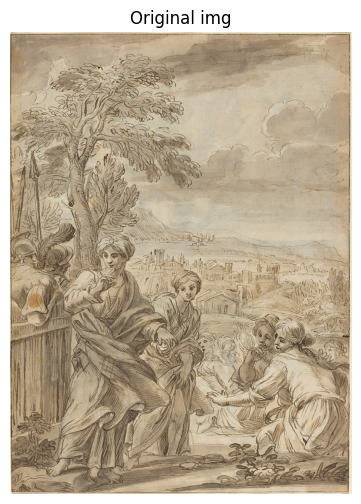

In [57]:
# ======================
# 1. 加载样例
# ======================

# 图片示例
sample_image_path = "ImgNationalGalleryOfArt/1024px-Angelo_Marullo,_Historical_Scene_(recto),_NGA_11380.jpg"  # 这里换成你的实际路径

# 读取图像
img = cv2.imread(sample_image_path) # 读取图像（格式为 BGR）

# OpenCV 默认是 BGR 格式，转换为 RGB，（Matplotlib 需要 RGB 才能正确显示）
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 显示原始图像
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original img")
plt.show()

In [58]:
# ======================
# 2. 预处理
# ======================

# 预处理：归一化 & 颜色调整
preprocess = transforms.Compose([
    # transforms.ToPILImage(), # 把 NumPy 数组转换为 PIL 格式 #########!!!!!!
    transforms.Resize(image_size), #调整所有图片大小，确保输入网络的尺寸一致
    # 绘画作品的风格可能不同，所以颜色抖动适应不同风格
    transforms.ColorJitter(
                        brightness=0.2,  #在 ±20% 范围内随机调整亮度
                        contrast=0.2, #在 ±20% 范围内随机调整对比度
                        saturation=0.2, #在 ±20% 范围内随机调整颜色饱和度
                        hue=0.1 #在 ±10% 范围内随机调整色调
                        ),  
    transforms.ToTensor(), #将 PIL.Image 转换为 PyTorch 张量，并将像素值归一化到 [0,1]
    transforms.Normalize( #ImageNet 预训练模型的标准化参数
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]
                        ),
])

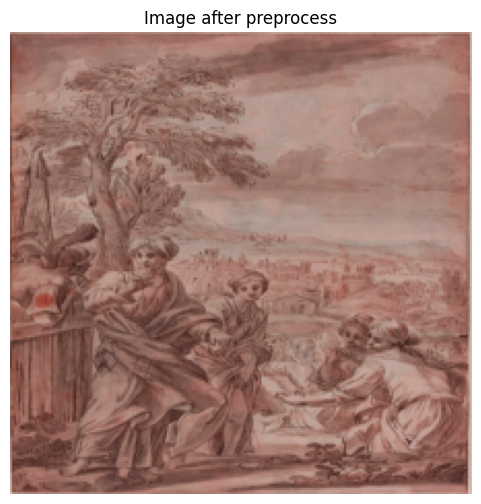

In [59]:
# 进行预处理    
# 图片可能会有轻微的颜色调整（归一化影响不大）
# 在颜色对比度上可能有细微变化，但人眼难以察觉

# 预处理：归一化 & 颜色调整
preprocessForExample = transforms.Compose([
    transforms.ToPILImage(), # 把 NumPy 数组转换为 PIL 格式 #########!!!!!!
    transforms.Resize(image_size), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1 ),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),])
img_tensor = preprocessForExample(img_rgb)

# 转回 numpy 格式，方便显示
img_np = img_tensor.permute(1, 2, 0).numpy()
img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # 反归一化
img_np = np.clip(img_np, 0, 1)

# 显示预处理后的图像
plt.figure(figsize=(6, 6))
plt.imshow(img_np)
plt.axis("off")
plt.title("Image after preprocess")
plt.show()

In [60]:
# ==============================================
# 3. 加载模型 (MTCNN) 人脸检测
# ==============================================

# 用于检测图片中的人脸（返回多个检测到的面部）
# MTCNN 适用于检测绘画中的人脸，比 YOLO 更适合非真实照片
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mtcnn = MTCNN(keep_all=True,device=device) #允许检测多个面部

In [61]:
# ==============================================
# 4. 加载模型 (FaceNet) 人脸特征提取 
# ==============================================

# FaceNet，计算人脸特征向量
# VGGFace2，大规模人脸数据集，预训练模型能够提取高质量的面部特征
facenet = InceptionResnetV1(pretrained='vggface2').eval()

Face Embedding Shape: torch.Size([1, 512])


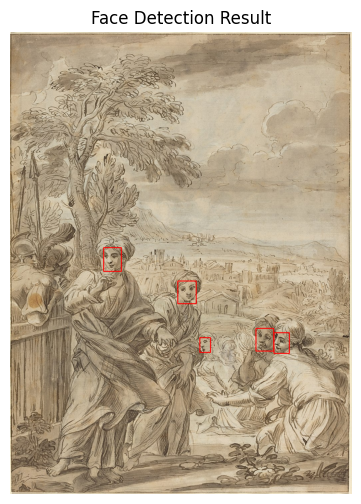

In [62]:
# 转换为 PIL 格式
img_pil = Image.fromarray(img_rgb)

# 人脸检测
faces = mtcnn(img_pil)

# 显示检测到的人脸
if faces is not None:
    face = faces[0].unsqueeze(0).to(device)  # 取第一张人脸，并增加 batch 维度
    with torch.no_grad():
        face_embedding = facenet(face)  # 提取特征向量

    print("Face Embedding Shape:", face_embedding.shape) # 这个 512 维向量是该人脸的特征表示，可用于相似度计算

    # 画出检测到的人脸区域
    img_face = img_rgb.copy()
    boxes, _ = mtcnn.detect(img_pil)
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_face, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # 显示检测到的人脸
    plt.figure(figsize=(6, 6))
    plt.imshow(img_face)
    plt.axis("off")
    plt.title("Face Detection Result")
    plt.show()
else:
    print("未检测到人脸")


In [63]:
# ==============================================
# 5. 加载模型 (ResNet) 整体风格特征提取
# ==============================================

# ResNet50，深度残差网络，
# 提取图片的整体视觉特征（风格、颜色、结构。。。
resnet_model = models.resnet50(pretrained=True)
resnet_model.eval()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [64]:
# ==============================================
# 6. 加载模型 (Mediapipe) 姿态估计
# ==============================================

#  Pose() 检测人体姿态，提取关键点用于计算姿势相似度
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

I0000 00:00:1742062935.270505 6812568 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3 Pro


In [65]:
# 进行姿态检测
results = pose.process(img_rgb) # 计算 17 个关键点（肩膀、胳膊、腿等）

# 绘制人体关键点
if results.pose_landmarks:
    img_pose = img_rgb.copy()
    for landmark in results.pose_landmarks.landmark:
        h, w, _ = img_pose.shape
        x, y = int(landmark.x * w), int(landmark.y * h)
        cv2.circle(img_pose, (x, y), 5, (255, 0, 0), -1)  # 红点表示关键点, 直观显示姿势

    # 显示带关键点的图片
    plt.figure(figsize=(6, 6))
    plt.imshow(img_pose)
    plt.axis("off")
    plt.title("Pose Detection Result")
    plt.show()
else:
    print("未检测到人体关键点")


# 输出 17 个关节点的坐标
if results.pose_landmarks:
    keypoints = np.array([[lm.x, lm.y] for lm in results.pose_landmarks.landmark])
    print("Extracted Keypoints:", keypoints)


未检测到人体关键点


W0000 00:00:1742062935.332828 6836479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742062935.343646 6836479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [66]:
# ===========================
# 7. 特征提取函数： 人脸特征提取
# ===========================

def extract_face_features(image):
    """ 提取人脸特征 """
    img_cvt = Image.fromarray(
                            cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #OpenCV 读取的图片是 BGR 格式，但 MTCNN 需要 RGB 格式，所以转换格式
                            )
    faces = mtcnn(img_cvt)  # 返回一个检测到的脸部裁剪图像（可能是多个）
    if faces is None:
        return None  # 没检测到人脸，返回空
    
    # 取第一张脸（如果有多个）,忽略多张脸的情况
    face = faces[0].unsqueeze(0)
    
    # 提取特征
    with torch.no_grad():
        face_embedding = facenet(face) #提取人脸特征向量,计算一个 512 维的特征向量,向量表示脸部信息（面部结构、轮廓等）
    
    return face_embedding.numpy().flatten() #展平为一维数组，便于计算相似度

In [67]:
extract_face_features(img_rgb)

array([-4.00166623e-02,  1.69770923e-02,  1.21014453e-02,  1.20871104e-01,
       -9.85827018e-03,  2.51103174e-02, -6.34175092e-02,  3.53935733e-02,
       -4.31160145e-02,  4.28164676e-02,  6.64773881e-02,  5.51608130e-02,
       -3.45025510e-02,  1.10739283e-03, -2.34282650e-02, -2.88237855e-02,
        4.13631946e-02,  1.38760790e-01,  1.00663062e-02, -1.74817499e-02,
        1.59063917e-02, -7.92111270e-03, -3.82091068e-02, -6.13244176e-02,
       -5.63229658e-02, -4.41927202e-02,  3.20844911e-02,  6.21518418e-02,
        2.52577271e-02,  1.71998478e-02,  9.15544981e-04, -5.22739477e-02,
        2.50593536e-02, -2.53502391e-02, -5.47608919e-02, -2.58715898e-02,
       -4.95912395e-02, -8.99754371e-03,  5.38388442e-04,  6.84772432e-02,
       -4.58340161e-02,  2.53078323e-02, -8.72629602e-03,  1.21065620e-02,
        3.54197063e-02,  2.39484683e-02,  2.60546207e-02,  1.90967936e-02,
       -2.91212052e-02, -1.74148977e-02, -7.61644123e-03,  8.34365666e-04,
        6.46864474e-02,  

In [68]:
# ===========================
# 8. 特征提取函数： 姿态特征提取
# ===========================

def extract_pose_features(image):
    """ 提取人体关键点特征 """
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #OpenCV 读取的图片是 BGR 格式，而 Mediapipe 需要 RGB 格式，所以转换
    results = pose.process(img_rgb) #计算人体关键点（17 个）（肩膀、胳膊、腿等）
    
    if results.pose_landmarks:
        keypoints = np.array([[lm.x, lm.y] for lm in results.pose_landmarks.landmark]) # lm.x, lm.y 获取 归一化的坐标（相对图片尺寸）
        return keypoints.flatten() #展平成一维数组，用于相似度计算
    
    return None  # 没检测到人体，返回空


In [69]:
extract_pose_features(img_rgb)

In [70]:
# 计算一个 2048 维的向量，表示图片风格和内容
def extract_image_features(image):
    """ 提取整张图片的视觉特征 """
    img_resized = preprocess(Image.fromarray(image)).unsqueeze(0)  # 预处理
    with torch.no_grad():
        features = resnet_model(img_resized) # 提取图片特征
    return features.numpy().flatten() # 展平为一维数组


In [71]:
extract_image_features(img_rgb)

array([-1.29568481e+00, -6.74851686e-02, -2.65016270e+00, -1.80176407e-01,
        3.77093732e-01,  1.65773228e-01,  6.07808530e-01,  1.96711838e-01,
       -1.47747147e+00, -6.87455833e-02, -2.45082879e+00, -2.28353667e+00,
       -6.17143810e-01, -1.06448162e+00, -2.51066238e-01, -1.07985365e+00,
       -2.70873189e+00, -2.19653511e+00, -3.81858647e-01, -1.04910040e+00,
       -1.25764632e+00, -1.21071208e+00, -2.74882585e-01,  4.96628940e-01,
       -1.22252572e+00, -1.38208282e+00, -1.04311502e+00, -5.54169893e-01,
       -1.45926511e+00, -9.63131011e-01, -9.40255761e-01, -1.15777326e+00,
        2.78846323e-01,  8.31405342e-01,  8.84288013e-01,  6.31923318e-01,
        1.92244613e+00,  1.15863240e+00,  5.76736987e-01,  2.82139063e-01,
       -1.92839062e+00,  6.30036533e-01, -1.37961817e+00,  1.05625045e+00,
        1.07937515e+00,  1.36459339e+00, -1.05995655e+00, -2.28488970e+00,
       -3.45347434e-01,  2.33277178e+00,  1.84523630e+00, -7.43585348e-01,
       -2.18882370e+00, -

In [72]:
# ======================
# 4. 计算相似性
# ======================

def compute_similarity(feature1, feature2, method='cosine'):
    """ 计算特征相似度 """
    if feature1 is None or feature2 is None:
        return 0  # 没有匹配特征时返回 0 相似度
    # 余弦相似度
    if method == 'cosine':
        return 1 - cosine(feature1, feature2)  # 两个向量的夹角，数值在 [0,1] 之间,数值越高越相似
    # 欧几里得距离 
    elif method == 'euclidean':
        return 1 / (1 + euclidean(feature1, feature2))  # 两个向量的几何距离，归一化到 [0,1]
    else:
        raise ValueError("Unsupported similarity method!")

In [73]:
# ======================
# 5. 计算数据集中的相似度
# ======================

# 计算所有图片的特征
image_features = []
face_features = []
pose_features = []

for path in image_paths:
    img = cv2.imread(path)
    
    # 提取特征
    image_feat = extract_image_features(img)
    face_feat = extract_face_features(img)
    pose_feat = extract_pose_features(img)
    
    image_features.append(image_feat)
    face_features.append(face_feat)
    pose_features.append(pose_feat)

# 转换为 NumPy 数组
image_features = np.array(image_features)
face_features = np.array(face_features, dtype=object)  # 可能有 None 值
pose_features = np.array(pose_features, dtype=object)

In [74]:
# ======================
# 6. 评估相似性
# ======================

def find_most_similar(target_idx, top_k=5):
    """ 在数据集中找到与目标图片最相似的前 K 张 """
    target_img_feat = image_features[target_idx]
    target_face_feat = face_features[target_idx]
    target_pose_feat = pose_features[target_idx]
    
    similarities = []
    
    for i in range(len(image_paths)):
        if i == target_idx:
            continue
        
        img_sim = compute_similarity(target_img_feat, image_features[i], method='cosine')
        face_sim = compute_similarity(target_face_feat, face_features[i], method='cosine')
        pose_sim = compute_similarity(target_pose_feat, pose_features[i], method='euclidean')
        
        # 计算综合相似度 (加权平均)
        total_sim = (0.5 * img_sim) + (0.3 * face_sim) + (0.2 * pose_sim)
        similarities.append((image_paths[i], total_sim))
    
    # 排序并返回最相似的 top_k 图片
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

In [75]:
# 测试：查询某张图的相似结果
query_idx = 10  # 任选一张图片
similar_images = find_most_similar(query_idx)

print("与目标图片最相似的 5 张图片：")
for img_path, sim_score in similar_images:
    print(f"{img_path} - 相似度: {sim_score:.4f}")

与目标图片最相似的 5 张图片：
ImgNationalGalleryOfArt/After_Pietro_da_Cortona,_Masinissa_and_Sophonisba,_NGA_65744.jpg - 相似度: 0.4260
ImgNationalGalleryOfArt/800px-Allan_Ramsay,_Lord_George_Villiers,_NGA_76122.jpg - 相似度: 0.4082
ImgNationalGalleryOfArt/800px-After_Francesco_Salviati,_Saint_Peter,_NGA_11388.jpg - 相似度: 0.4018
ImgNationalGalleryOfArt/1280px-Attributed_to_Gilbert_Stuart,_Mrs._Benjamin_Fisher,_NGA_62650.jpg - 相似度: 0.3977
ImgNationalGalleryOfArt/1920px-After_Sir_Peter_Paul_Rubens,_Tribute_Money,_NGA_11379.jpg - 相似度: 0.3951


/var/folders/ny/3djxxhdx4kz2zxhn2yx5jgqr0000gn/T/ipykernel_86079/4101778355.py:25: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from current font.
  plt.tight_layout()
/var/folders/ny/3djxxhdx4kz2zxhn2yx5jgqr0000gn/T/ipykernel_86079/4101778355.py:25: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()
/var/folders/ny/3djxxhdx4kz2zxhn2yx5jgqr0000gn/T/ipykernel_86079/4101778355.py:25: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
/var/folders/ny/3djxxhdx4kz2zxhn2yx5jgqr0000gn/T/ipykernel_86079/4101778355.py:25: UserWarning: Glyph 29255 (\N{CJK UNIFIED IDEOGRAPH-7247}) missing from current font.
  plt.tight_layout()
/var/folders/ny/3djxxhdx4kz2zxhn2yx5jgqr0000gn/T/ipykernel_86079/4101778355.py:25: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  plt.tight_layout()
/var/folders/ny/3djxxhdx4kz2zxhn2yx5jgqr0000gn/T/ipyker

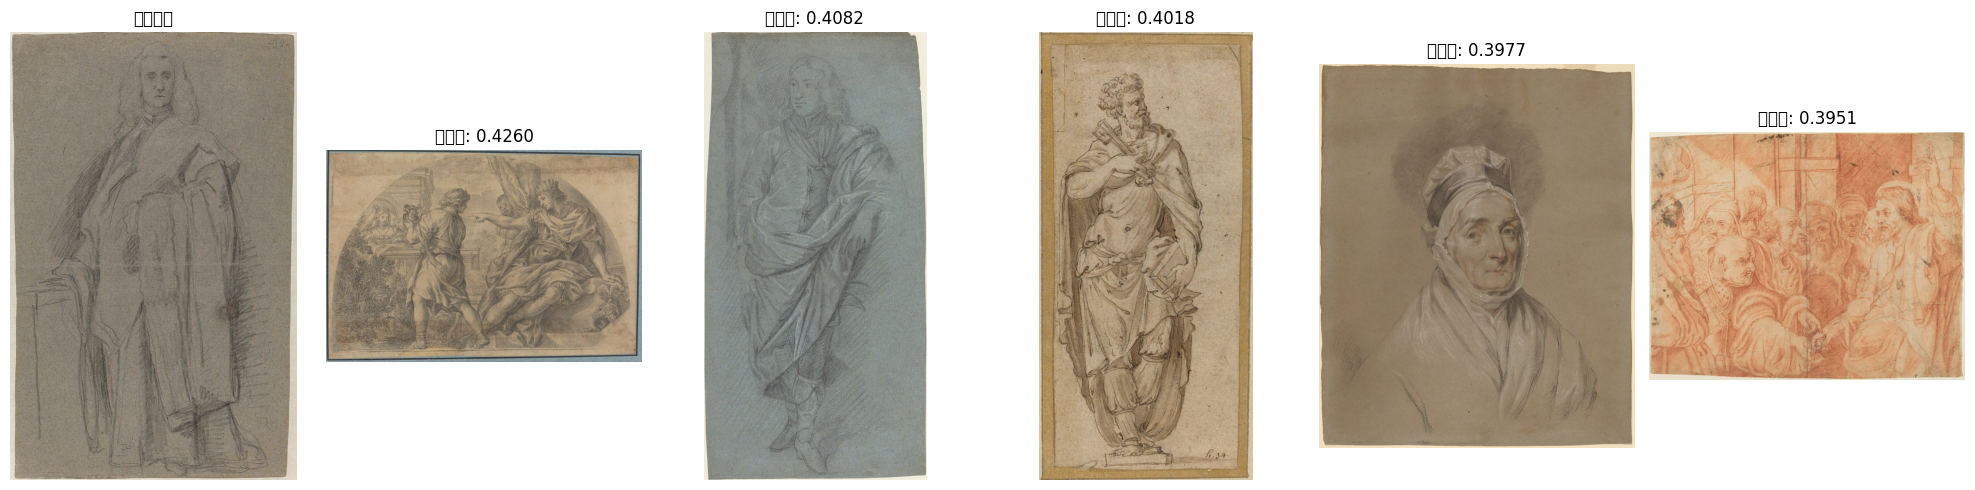

In [77]:
# 选择查询图片的索引
query_idx = 10  # 假设查询图片的索引是 10
similar_images = find_most_similar(query_idx)

# 获取目标图片路径
query_img_path = image_paths[query_idx]
query_img = cv2.imread(query_img_path)  # 读取目标图片

# 创建一个展示图像的窗口
fig, axes = plt.subplots(1, 6, figsize=(20, 5))  # 一行显示 6 张图片

# 显示目标图片
axes[0].imshow(cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB))
axes[0].axis('off')  # 关闭坐标轴
axes[0].set_title(f"目标图片")

# 显示与目标图片最相似的 5 张图片
for i, (img_path, sim_score) in enumerate(similar_images[:5]):
    img = cv2.imread(img_path)  # 读取相似图片
    axes[i + 1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i + 1].axis('off')  # 关闭坐标轴
    axes[i + 1].set_title(f"相似度: {sim_score:.4f}")

# 显示所有图片
plt.tight_layout()
plt.show()
